### Data Cleaning & Exploratory Data Analysis (EDA)

**Goal**:  
- Load the enriched CSV
- Perform basic cleaning (missing values, types, outliers)  
- Engineer additional features (rolling volatility, monthly aggregates)  
- Visualize key patterns (prices, returns, volume, volatility)  
- Extract initial business insights & recommendations

**Relevance**:  
Shows ability to ensure data quality, translate raw data into actionable insights, create visualizations, and communicate findings.

#### Imports & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Better looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# Load the enriched file from Phase 1
df = pd.read_csv('crypto_transactional_data_enriched.csv')

df['daily_return'] = df.groupby('coin')['price'].pct_change()
df['volatility_14d'] = df.groupby('coin')['daily_return'].transform(
    lambda x: x.rolling(window=14, min_periods=7).std()
)

# Re-save
df.to_csv('crypto_transactional_data_enriched.csv', index=False)
print("CSV updated with volatility_14d")

# Convert timestamp to datetime (very important)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("Loaded dataset shape:", df.shape)
print("\nColumns and types:\n", df.dtypes)
print("\nFirst 3 rows:")
print(df.head(3))
print("\nLast 3 rows:")
print(df.tail(3))

CSV updated with volatility_14d
Loaded dataset shape: (732, 10)

Columns and types:
 timestamp              datetime64[ns]
price                         float64
volume                        float64
market_cap                    float64
coin                           object
transaction_count               int64
avg_txn_fee_usd               float64
total_txn_value_usd           float64
daily_return                  float64
volatility_14d                float64
dtype: object

First 3 rows:
   timestamp          price        volume    market_cap     coin  \
0 2025-01-14   94456.349375  7.632833e+10  1.870609e+12  Bitcoin   
1 2025-01-15   96574.077688  5.124173e+10  1.912603e+12  Bitcoin   
2 2025-01-16  100313.152398  5.763732e+10  1.986831e+12  Bitcoin   

   transaction_count  avg_txn_fee_usd  total_txn_value_usd  daily_return  \
0             201958         5.358532         1.082198e+06           NaN   
1             226867         4.282332         9.715197e+05      0.022420   
2    

#### Cleaning & Validation

In [2]:
print("=== Cleaning & Validation ===")

# 1. Missing values
print("\nMissing values:\n", df.isnull().sum())

# Forward fill any rare gaps in price/volume (time-series friendly)
df[['price','volume','market_cap']] = df[['price','volume','market_cap']].fillna(method='ffill')

# The first daily_return per coin is NaN → that's expected
print("\nAfter fill:\n", df.isnull().sum())

# 2. Check for duplicates (unlikely but good practice)
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()

# 3. Extreme values check (crypto has big moves, so only flag very suspicious)
print("\nTop 5 highest prices:\n", df.nlargest(5, 'price')[['timestamp','coin','price']])
print("\nTop 5 highest volumes:\n", df.nlargest(5, 'volume')[['timestamp','coin','volume']])

=== Cleaning & Validation ===

Missing values:
 timestamp               0
price                   0
volume                  0
market_cap              0
coin                    0
transaction_count       0
avg_txn_fee_usd         0
total_txn_value_usd     0
daily_return            2
volatility_14d         14
dtype: int64

After fill:
 timestamp               0
price                   0
volume                  0
market_cap              0
coin                    0
transaction_count       0
avg_txn_fee_usd         0
total_txn_value_usd     0
daily_return            2
volatility_14d         14
dtype: int64


C:\Users\Eldu\AppData\Local\Temp\ipykernel_15124\1187293986.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['price','volume','market_cap']] = df[['price','volume','market_cap']].fillna(method='ffill')



Number of duplicate rows: 0

Top 5 highest prices:
      timestamp     coin          price
266 2025-10-07  Bitcoin  124773.508231
212 2025-08-14  Bitcoin  123560.993636
265 2025-10-06  Bitcoin  123506.185200
268 2025-10-09  Bitcoin  123352.504875
264 2025-10-05  Bitcoin  122380.937085

Top 5 highest volumes:
      timestamp     coin        volume
270 2025-10-11  Bitcoin  1.510022e+11
312 2025-11-22  Bitcoin  1.350935e+11
21  2025-02-04  Bitcoin  1.221640e+11
7   2025-01-21  Bitcoin  1.201585e+11
305 2025-11-15  Bitcoin  1.131983e+11


#### Feature Engineering

In [3]:
print("=== Feature Engineering ===")

# 1. 14-day rolling volatility (standard deviation of daily returns)
df['volatility_14d'] = df.groupby('coin')['daily_return'].transform(
    lambda x: x.rolling(window=14, min_periods=7).std()
)

# 2. Monthly aggregates for dashboard/reporting
df['month'] = df['timestamp'].dt.to_period('M')

monthly = df.groupby(['coin', 'month']).agg({
    'price': ['mean', 'min', 'max'],
    'volume': 'sum',
    'total_txn_value_usd': 'sum',
    'daily_return': ['mean', 'std']
}).reset_index()

# Flatten multi-level columns
monthly.columns = ['coin', 'month', 'avg_price', 'min_price', 'max_price',
                   'total_volume', 'total_txn_value_usd', 'avg_daily_return', 'return_std']

print("\nMonthly aggregates (first 6 rows):")
print(monthly.head(6))

=== Feature Engineering ===

Monthly aggregates (first 6 rows):
      coin    month      avg_price      min_price      max_price  \
0  Bitcoin  2025-01  102266.814044   94456.349375  106182.236820   
1  Bitcoin  2025-02   95922.849136   83900.114965  102382.394097   
2  Bitcoin  2025-03   85158.743788   78783.940579   94261.532865   
3  Bitcoin  2025-04   86068.125203   76329.090356   95030.606455   
4  Bitcoin  2025-05  103284.770614   94235.753310  111560.356938   
5  Bitcoin  2025-06  105714.032371  100852.582646  110261.574859   

   total_volume  total_txn_value_usd  avg_daily_return  return_std  
0  1.123188e+12         3.267908e+07          0.006343    0.021817  
1  1.208236e+12         6.910406e+07         -0.007348    0.021162  
2  1.076548e+12         6.735879e+07         -0.000323    0.034814  
3  1.011116e+12         5.253233e+07          0.004921    0.029383  
4  1.046452e+12         5.980517e+07          0.003340    0.018219  
5  8.525042e+11         7.359305e+07         

#### Visualizations 

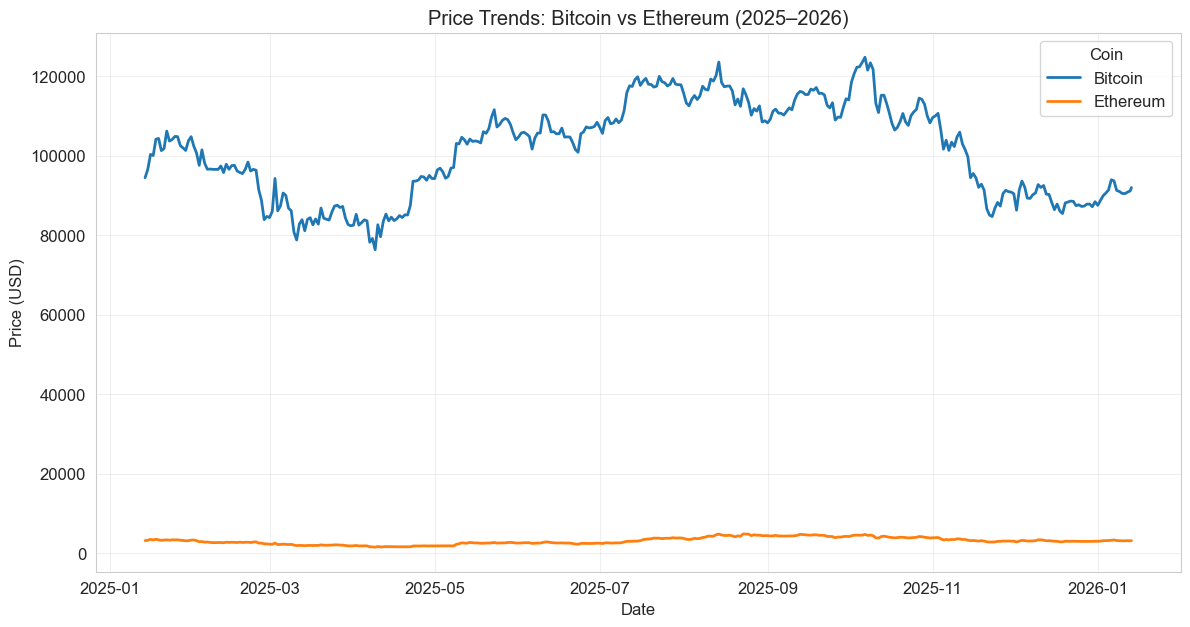

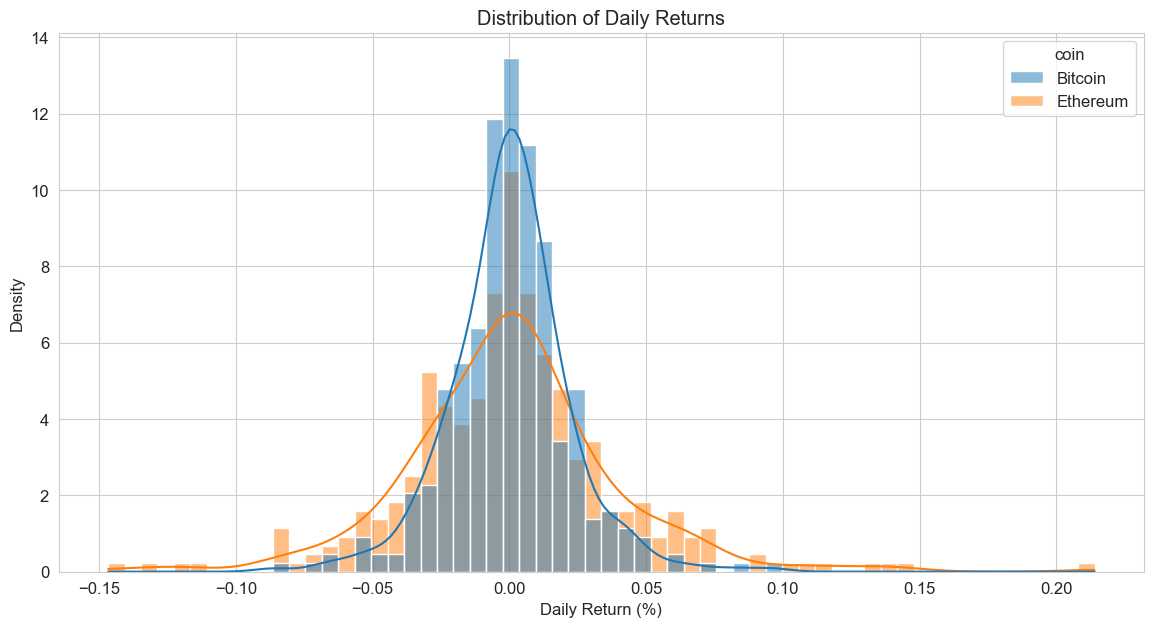

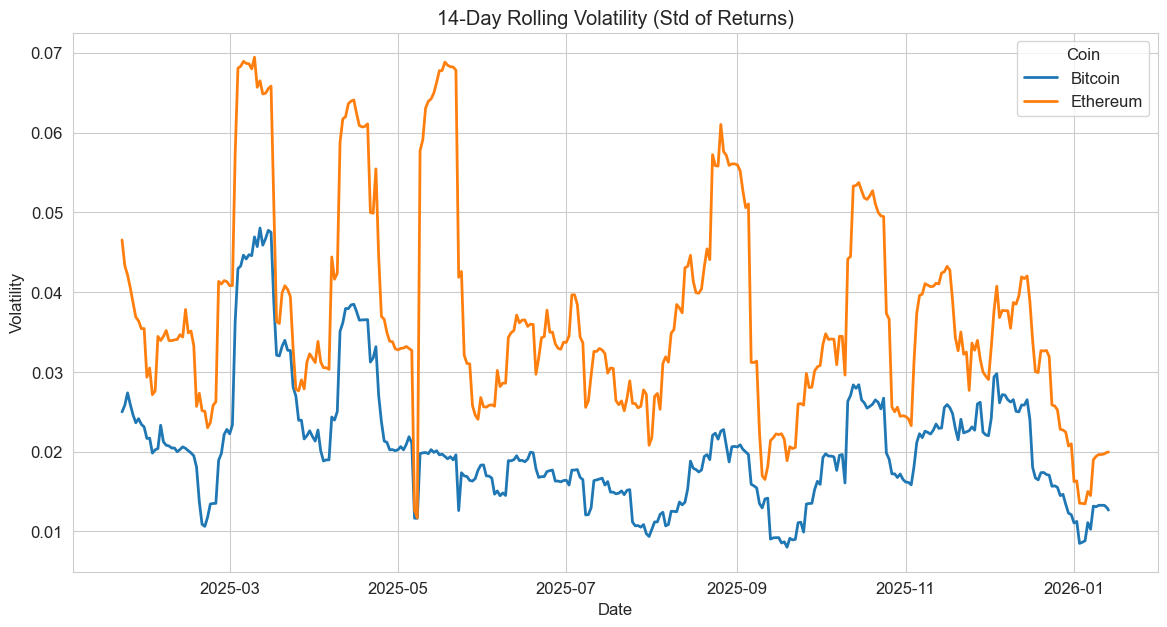

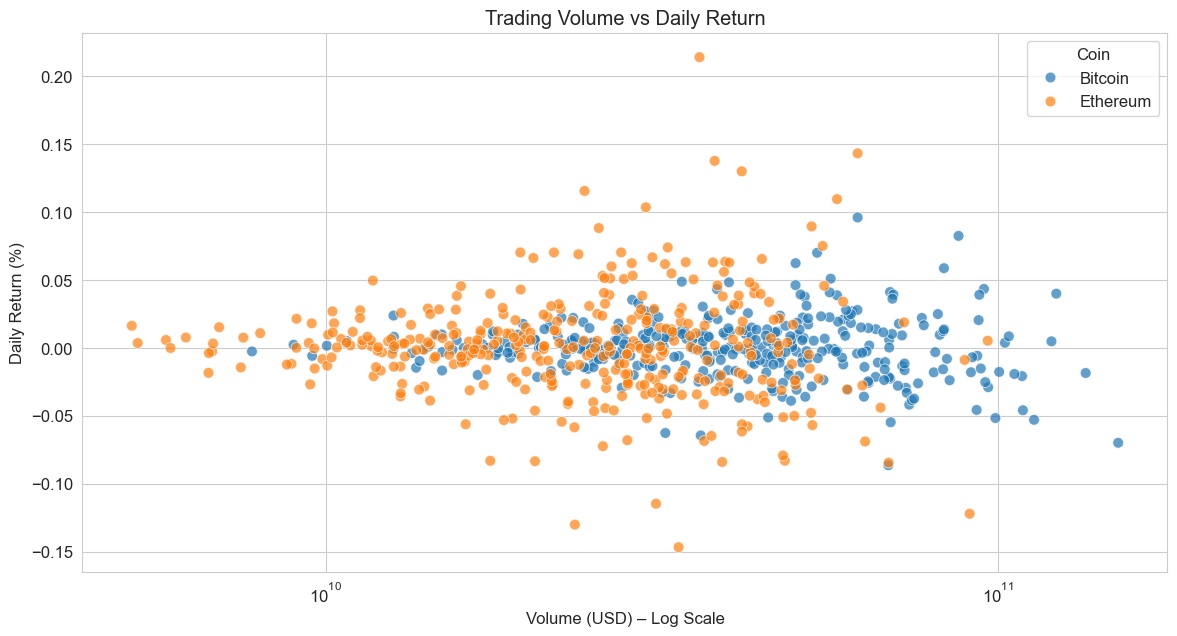

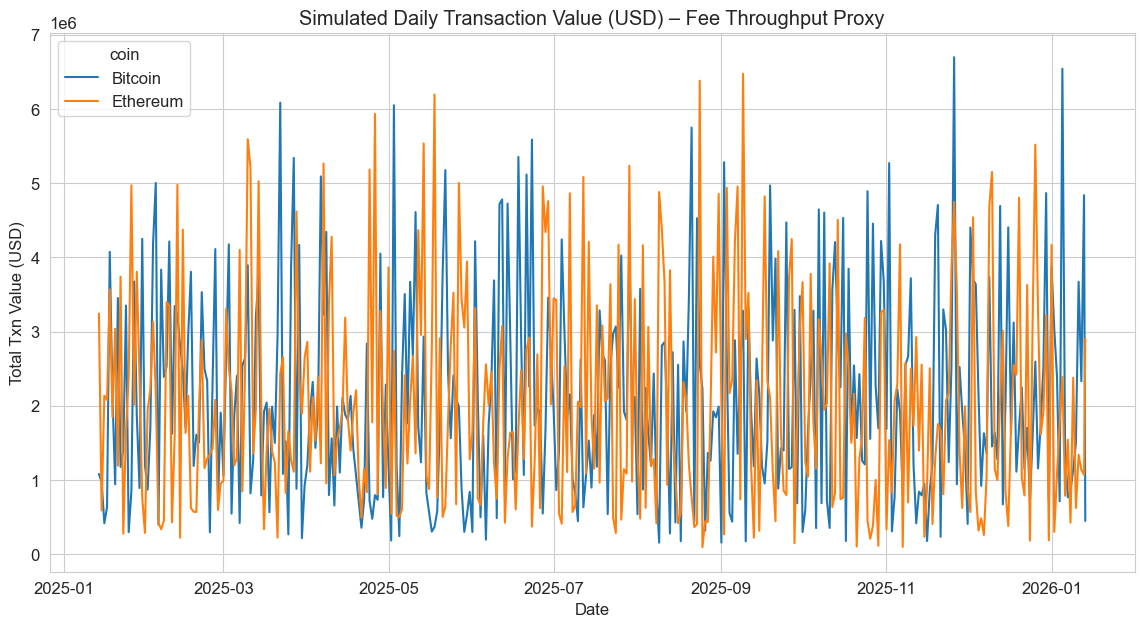

In [4]:
#Price Trends: Bitcoin vs Ethereum (2025–2026)
plt.figure()
sns.lineplot(data=df, x='timestamp', y='price', hue='coin', linewidth=2)
plt.title('Price Trends: Bitcoin vs Ethereum (2025–2026)')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend(title='Coin')
plt.grid(True, alpha=0.3)
plt.show()

# Daily returns distribution
plt.figure()
sns.histplot(data=df, x='daily_return', hue='coin', kde=True, bins=60, stat='density')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Density')
plt.show()

# 14-day rolling volatility
plt.figure()
sns.lineplot(data=df, x='timestamp', y='volatility_14d', hue='coin', linewidth=2)
plt.title('14-Day Rolling Volatility (Std of Returns)')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.legend(title='Coin')
plt.show()

# Volume vs Daily Return (scatter)
plt.figure()
sns.scatterplot(data=df, x='volume', y='daily_return', hue='coin', alpha=0.7, s=60)
plt.xscale('log')
plt.title('Trading Volume vs Daily Return')
plt.xlabel('Volume (USD) – Log Scale')
plt.ylabel('Daily Return (%)')
plt.legend(title='Coin')
plt.show()

# Simulated total txn value over time
plt.figure()
sns.lineplot(data=df, x='timestamp', y='total_txn_value_usd', hue='coin')
plt.title('Simulated Daily Transaction Value (USD) – Fee Throughput Proxy')
plt.ylabel('Total Txn Value (USD)')
plt.xlabel('Date')
plt.show()

#### Insights & Recommendations

In [5]:
print("Average daily return & volatility by coin:")
print(df.groupby('coin').agg({
    'daily_return': ['mean', 'std', 'min', 'max'],
    'volatility_14d': 'mean'
}).round(4))

print("\nCorrelation between volume and daily return:")
df[['volume', 'daily_return', 'total_txn_value_usd']].corr().round(3)

Average daily return & volatility by coin:
         daily_return                         volatility_14d
                 mean     std     min     max           mean
coin                                                        
Bitcoin        0.0002  0.0216 -0.0863  0.0960         0.0205
Ethereum       0.0008  0.0391 -0.1466  0.2139         0.0371

Correlation between volume and daily return:


,volume,daily_return,total_txn_value_usd
volume,1.000,-0.060,0.054
daily_return,-0.060,1.000,0.021
total_txn_value_usd,0.054,0.021,1.000


### Recommendations for Finance & Treasury Teams

1. **Volatility Monitoring**  
   - Set alerts when 14-day volatility exceeds 0.04–0.05 (especially for Ethereum positions).  
   - Higher volatility in ETH suggests tighter risk limits or more frequent rebalancing for treasury holdings.

2. **Volume as Liquidity Signal**  
   - Although volume–return correlation is weak, volume surges (>75th percentile) can still serve as a leading indicator for increased liquidity risk or opportunity.  
   - Recommend tracking volume spikes in daily dashboards for proactive treasury adjustments.

3. **Fee Revenue Proxy**  
   - Simulated `total_txn_value_usd` shows independence from price direction → useful as a stable throughput metric for forecasting operational fee income, even in sideways or down markets.

4. **Reporting & Dashboard Priorities**  
   - Build monthly aggregates (avg_price, total_volume, total_txn_value_usd) into Looker dashboards for self-service access by Finance/Treasury.  
   - Include per-coin volatility and return stats in recurring financial performance reports.

5. **Next Steps**  
   - Create queries to rank highest-volatility periods and identify volume outliers.  
   - Consider adding external factors (e.g., BTC dominance, on-chain metrics) in future iterations for deeper causal analysis.

**Overall**: The dataset reveals Ethereum's higher risk/reward profile compared to Bitcoin — valuable for portfolio allocation, hedging strategy, and customer education in a crypto banking context.